# Visualize grit as compared to replicate reproducibility

Grit combines the concepts of replicate reproducibility and difference from controls.

Here, observe how grit handles the tradeoff between calculating each independently.

In [1]:
import pathlib
import pandas as pd
import plotnine as gg

In [2]:
output_dir = pathlib.Path("figures/replicate_reproducibility")

cell_health_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_grit.tsv")
reprod_file = pathlib.Path(f"{cell_health_dir}/cell_health_replicate_reproducibility.tsv")

In [3]:
replicate_reproducibility_theme = gg.theme(
    strip_background=gg.element_rect(color="black", fill="#fdfff4"),
    strip_text_x=gg.element_text(size=6),
    axis_text=gg.element_text(size=7),
    axis_title=gg.element_text(size=8),
    legend_title=gg.element_text(size=6),
    legend_text=gg.element_text(size=5),
    legend_key_size=10,
    legend_key_width=10,
    legend_key_height=10,
    panel_grid=gg.element_line(size=0.35)
)

In [4]:
# Load and process data
grit_df = pd.read_csv(grit_file, sep="\t").query("barcode_control == 'cutting_control'").query("cor_method == 'pearson'")
reprod_df = pd.read_csv(reprod_file, sep="\t")

grit_df = (
    grit_df.merge(
        reprod_df,
        on=["perturbation", "group", "cell_line"],
        how="inner"
    )
    .dropna()
)

grit_df = grit_df.assign(
    replicate_over_cor=grit_df.median_replicate_correlation / grit_df.median_control_correlation,
    replicate_over_oneminuscor=grit_df.median_replicate_correlation / (1 - grit_df.median_control_correlation)
)
grit_df.replicate_over_cor = grit_df.replicate_over_cor.abs()

print(grit_df.shape)
grit_df.head()

(339, 10)


,perturbation,group,grit,cell_line,barcode_control,cor_method,median_replicate_correlation,median_control_correlation,replicate_over_cor,replicate_over_oneminuscor
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,0.312738,-0.015761,19.842424,0.307885
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,0.152056,0.007979,19.057880,0.153279
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson,0.186862,0.054083,3.455095,0.197546
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson,0.211846,0.033912,6.246934,0.219283
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson,0.754919,0.118991,6.344323,0.856881


/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 5 in image.
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/replicate_reproducibility/cell_health_grit_replicate_reproduce.png


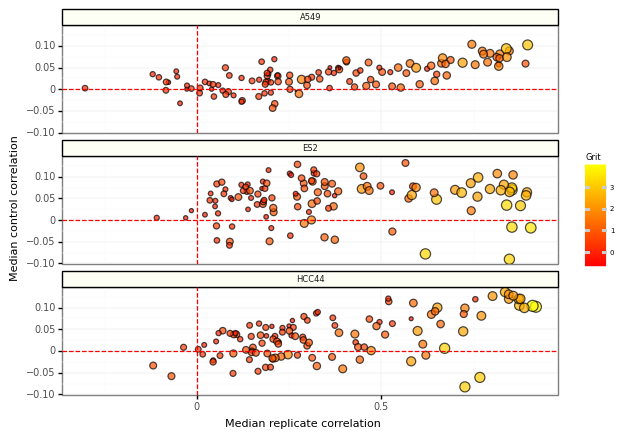

<ggplot: (404472375)>

In [5]:
replicate_gg = (
    gg.ggplot(grit_df, gg.aes(x="median_replicate_correlation", y="median_control_correlation"))
    + gg.geom_point(gg.aes(fill="grit", size="grit"), alpha=0.7)
    + gg.scale_fill_gradient(name="Grit", high="yellow", low="red")
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Median replicate correlation")
    + gg.ylab("Median control correlation")
    + replicate_reproducibility_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_replicate_reproduce.png")
replicate_gg.save(output_file, dpi=500, height=5, width=3)

replicate_gg

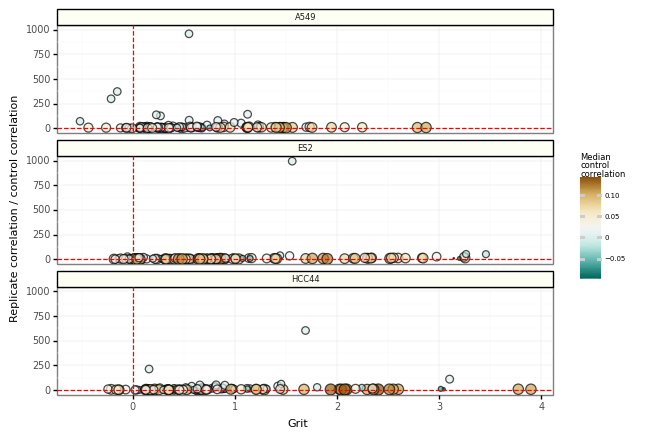

<ggplot: (404388130)>

In [6]:
replicate_gg = (
    gg.ggplot(grit_df, gg.aes(x="grit", y="replicate_over_cor"))
    + gg.geom_point(gg.aes(fill="median_control_correlation", size="median_control_correlation"), alpha=0.7)
    + gg.scale_fill_distiller(name="Median\ncontrol\ncorrelation\n", type='div')
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / control correlation")
    + replicate_reproducibility_theme
)

replicate_gg

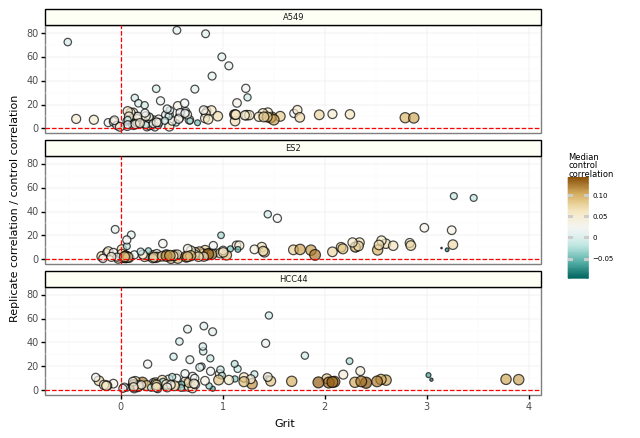

<ggplot: (406769159)>

In [7]:
replicate_gg = (
    gg.ggplot(grit_df.query("replicate_over_cor < 100"), gg.aes(x="grit", y="replicate_over_cor"))
    + gg.geom_point(gg.aes(fill="median_control_correlation", size="median_control_correlation"), alpha=0.7)
    + gg.scale_fill_distiller(name="Median\ncontrol\ncorrelation\n", type='div')
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / control correlation")
    + replicate_reproducibility_theme
)

replicate_gg

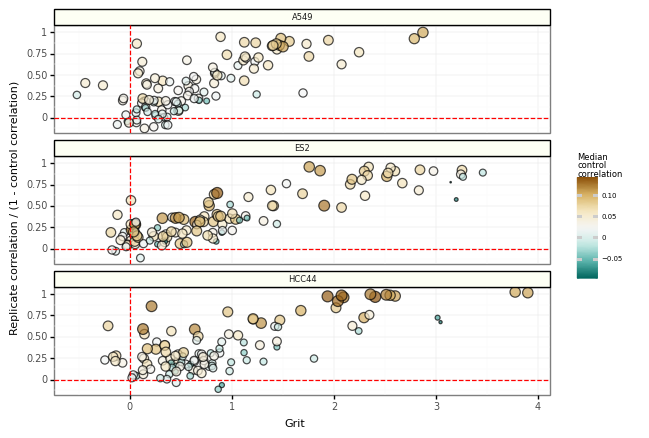

<ggplot: (406768903)>

In [8]:
replicate_gg = (
    gg.ggplot(grit_df.query("replicate_over_cor < 100"), gg.aes(x="grit", y="replicate_over_oneminuscor"))
    + gg.geom_point(gg.aes(fill="median_control_correlation", size="median_control_correlation"), alpha=0.7)
    + gg.scale_fill_distiller(name="Median\ncontrol\ncorrelation\n", type='div')
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / (1 - control correlation)")
    + replicate_reproducibility_theme
)

replicate_gg

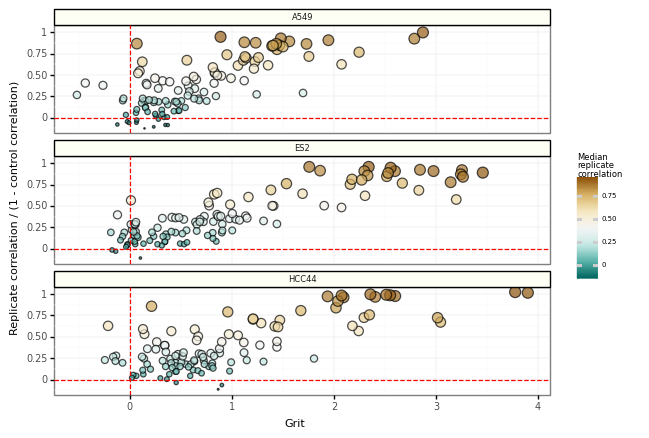

<ggplot: (407175798)>

In [9]:
replicate_gg = (
    gg.ggplot(grit_df.query("replicate_over_cor < 100"), gg.aes(x="grit", y="replicate_over_oneminuscor"))
    + gg.geom_point(gg.aes(fill="median_replicate_correlation", size="median_replicate_correlation"), alpha=0.7)
    + gg.scale_fill_distiller(name="Median\nreplicate\ncorrelation\n", type='div')
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / (1 - control correlation)")
    + replicate_reproducibility_theme
)

replicate_gg